In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
l=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        l.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

In [5]:
data = pd.read_csv(l[0])
data.head()

,Series_Capacitor,Parallel_Capacitor,S11_Magnitude
0,0.9,1.0,"[0.8325977276125222, 0.4948060278017322, 0.883..."
1,0.9,1.5,"[0.24892524156172813, 0.6538996717639047, 0.40..."
2,0.9,2.0,"[0.8336109748651374, 0.8658503999556663, 0.611..."
3,0.9,2.5,"[0.19416407455843265, 0.29245020960145807, 0.7..."
4,0.9,3.0,"[0.060469226037731416, 0.5101101910901806, 0.6..."


In [6]:
data.to_csv('s11_data.csv')

In [7]:
len(data.S11_Magnitude[0])

8130

In [8]:
def string_to_float_list(string):
    # Remove the square brackets and split by comma
    cleaned_string = string.strip('[]')  # Remove '[' and ']'
    number_strings = cleaned_string.split(',')  # Split by comma
    
    # Convert each substring to float, handling potential whitespace
    float_list = [float(num.strip()) for num in number_strings if num.strip()]
    
    return float_list
data['S11']=data['S11_Magnitude'].apply(string_to_float_list)

In [9]:
data.head()

,Series_Capacitor,Parallel_Capacitor,S11_Magnitude,S11
0,0.9,1.0,"[0.8325977276125222, 0.4948060278017322, 0.883...","[0.8325977276125222, 0.4948060278017322, 0.883..."
1,0.9,1.5,"[0.24892524156172813, 0.6538996717639047, 0.40...","[0.24892524156172813, 0.6538996717639047, 0.40..."
2,0.9,2.0,"[0.8336109748651374, 0.8658503999556663, 0.611...","[0.8336109748651374, 0.8658503999556663, 0.611..."
3,0.9,2.5,"[0.19416407455843265, 0.29245020960145807, 0.7...","[0.19416407455843265, 0.29245020960145807, 0.7..."
4,0.9,3.0,"[0.060469226037731416, 0.5101101910901806, 0.6...","[0.060469226037731416, 0.5101101910901806, 0.6..."


In [10]:
len(data.S11[0])

401

In [11]:
col = data.S11
X = torch.tensor(col)
y1 = torch.tensor(data.Series_Capacitor)
y2 = torch.tensor(data.Parallel_Capacitor)
y = torch.stack([y1,y2])

In [12]:
y1 = torch.tensor(data.Series_Capacitor)
y2 = torch.tensor(data.Parallel_Capacitor)
y = torch.stack([y1,y2]).permute([1,0])
y.shape

torch.Size([377, 2])

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
train_ds=TensorDataset(X,y.float())
test_ds = TensorDataset(X_test,y_test.float())
train_loader = DataLoader(train_ds,shuffle=True,batch_size=16)
val_loader = DataLoader(test_ds,shuffle=True,batch_size=16)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.4):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.norm1 = nn.LayerNorm(out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.match_dims = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        residual = self.match_dims(x)
        out = self.linear1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        return out + residual  # Residual connection

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_block = nn.Sequential(
            nn.Linear(401, 256), # 512
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.res_blocks = nn.Sequential(
            ResidualBlock(256, 256),
            ResidualBlock(256, 128),
            ResidualBlock(128, 64)
        )

        # Branch 1 for `cs`
        self.branch_cs = nn.Sequential(
            ResidualBlock(64, 32),
            nn.Linear(32, 1)
        )

        # Branch 2 for `cp`
        self.branch_cp = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 32),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.input_block(x)
        x = self.res_blocks(x)
        cs = self.branch_cs(x)
        cp = self.branch_cp(x)
        return torch.cat((cs, cp), dim=1)

model = Model()
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs=100
train_loss_log = []
val_loss_log = []
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        # inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  
        loss = criterion(outputs, targets)  

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Print epoch loss
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_log.append(epoch_loss)
    
    

    model.eval()
    val_running_loss = 0.0
    with torch.inference_mode():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            val_running_loss += val_loss.item() * val_inputs.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_loss_log.append(val_epoch_loss)
    if(epoch%10==0):
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {val_epoch_loss:.4f}")

Epoch [1/100], Train Loss: 19.6138, Test Loss: 9.5705
Epoch [11/100], Train Loss: 8.8975, Test Loss: 8.1470
Epoch [21/100], Train Loss: 4.5181, Test Loss: 3.2643
Epoch [31/100], Train Loss: 2.6027, Test Loss: 1.6581
Epoch [41/100], Train Loss: 1.5288, Test Loss: 0.7966
Epoch [51/100], Train Loss: 1.0707, Test Loss: 0.7042
Epoch [61/100], Train Loss: 0.8624, Test Loss: 0.7571
Epoch [71/100], Train Loss: 0.7369, Test Loss: 0.4501
Epoch [81/100], Train Loss: 0.5818, Test Loss: 0.1810
Epoch [91/100], Train Loss: 0.5557, Test Loss: 0.1331


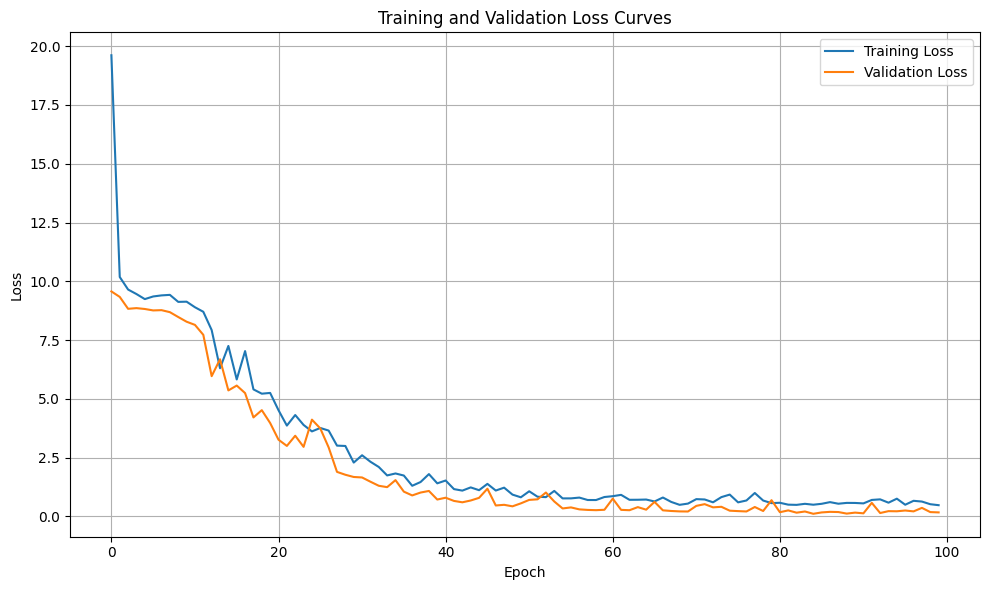

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_log, label='Training Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
X1 = X_test[77]
X2 = X_test[99]
X=torch.stack([X1,X2])
X.shape

torch.Size([2, 401])

In [26]:
X1 = X_test[77]
X2 = X_test[99]
X=torch.stack([X1,X2])
model.eval()
with torch.inference_mode():
    y1_pred = model(X)
print(y1_pred,torch.stack([y_test[77],y_test[99]]))

tensor([[2.3172, 9.2499],
        [1.2430, 6.6790]]) tensor([[ 2.3000, 10.0000],
        [ 0.9000,  7.5000]], dtype=torch.float64)
